In this notebook, we compare some out of the box models to the ELM prior with respect to our set of constraints

In [1]:
import pickle
from collections import OrderedDict

import numpy as np
from periodictable import elements

In [2]:
from exfor_tools import curate, quantities, reaction

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [3]:
from jitr import rmatrix
from jitr.optical_potentials import kduq, wlh
from jitr.utils import kinematics
from jitr.xs.elastic import DifferentialWorkspace
from jitr import data_dir

In [4]:
import elm

In [5]:
proton = (1,1)
neutron = (1,0)

In [6]:
with open("nn_elastic_data.pkl", "rb") as f:
    nn_data = pickle.load(f)

In [7]:
with open("pp_elastic_data.pkl", "rb") as f:
    pp_data = pickle.load(f)

In [8]:
all_data = list(pp_data.values()) + list(nn_data.values())
all_data_by_entry, sys_uncertainties_by_entry = (
    curate.cross_reference_entry_systematic_err(all_data)
)

In [9]:
measurement_groups = curate.categorize_measurements_by_energy(
    pp_data[(40, 20)].data["dXS/dA"].entries
)

In [11]:
default_sys_norm_err = 0.05
constraints = []
core_solver = rmatrix.Solver(40)
angles_vis = np.linspace(0.01, 180, 100)

for measurement_group in measurement_groups:
    for m in measurement_group:
        
        # assign default systematic normalization error
        if np.isclose(m.systematic_norm_err, 0):
            m.systematic_norm_err = default_sys_norm_err

        # convert to mB/Sr TODO put convert function in exfor_tools and do this during parsing
        if m.y_units == 'barns/ster':
            m.y_units = 'mb/Sr'
            m.y *= 1000
            m.statistical_err *= 1000
            m.systematic_offset_err *= 1000
            m.general_systematic_err *= 1000
            for i in range(len(m.y_errs)):
                m.y_errs[i] *= 1000
            
        model = elm.ElasticModel(
                quantity="dXS/dRuth",
                reaction=pp_data[(40, 20)].reaction,
                Elab=m.Einc,
                angles_rad_constraint=m.x * np.pi / 180,
                angles_rad_vis=angles_vis * np.pi / 180,
                core_solver=core_solver,
                lmax=30,
            )
        constraint = elm.calibration.ReactionDistribution(
                quantity="dXS/dRuth",
                measurement=m,
                normalize=model.constraint_workspace.rutherford
            )
        constraints.append((constraint, model))

## Parameters

### ELM prior

In [12]:
with open("../prior/prior_distribution.pickle", "rb") as f:
    prior = pickle.load(f)

In [13]:
prior_samples = prior.rvs(size=1000)

In [14]:
prior_samples = [OrderedDict([(p.name, v) for p, v in zip(elm.params, sample)]) for sample in prior_samples]

## kduq

In [15]:
kd_samples = kduq.get_samples_federal(proton)

In [16]:
def kduq_calculate_xs(workspace: DifferentialWorkspace, params: OrderedDict):
    coul, cen, so = kduq.calculate_params(proton, tuple(workspace.reaction.target), workspace.kinematics.Elab, params)
    return workspace.xs(
        interaction_central=kduq.central_plus_coulomb,
        interaction_spin_orbit=kduq.spin_orbit,
        args_central=(cen, coul),
        args_spin_orbit=so
    )

## WLH

In [17]:
wlh_samples = wlh.get_samples(proton)

In [18]:
def wlh_calculate_xs(workspace: DifferentialWorkspace, params: OrderedDict):
    coul, cen, so = wlh.calculate_params(proton, tuple(workspace.reaction.target), workspace.kinematics.Elab, params)
    return workspace.xs(
        interaction_central=wlh.central_plus_coulomb,
        interaction_spin_orbit=wlh.spin_orbit,
        args_central=(cen, coul),
        args_spin_orbit=so
    )

# Run UQ

In [19]:
def run_uq_vis(model, func, params):
    xs = np.zeros((len(params), len(angles_vis)))
    for i in range(len(params)):
        xs[i, :] = (
        model.get_quantity_vis(
            func,
            params[i],
        )
        )
    return np.percentile(xs, [16, 84], axis=0)

In [20]:
len(constraints)
i = 0

In [21]:
kduq_confint = run_uq_vis(constraints[i][1], kduq_calculate_xs, kd_samples)

/home/beyerk/Projects/jitr/src/jitr/optical_potentials/kduq.py:302: RuntimeWarning: overflow encountered in exp
  1 + np.exp((A - params["d2_A3"]) / params["d2_A2"])


In [22]:
wlh_confint = run_uq_vis(constraints[i][1], wlh_calculate_xs, wlh_samples)

In [23]:
wlh_confint = run_uq_vis(constraints[i][1], wlh_calculate_xs, wlh_samples)

In [24]:
elm_prior_confint = run_uq_vis(constraints[i][1], elm.calculate_diff_xs, prior_samples)

In [25]:
from matplotlib import pyplot as plt

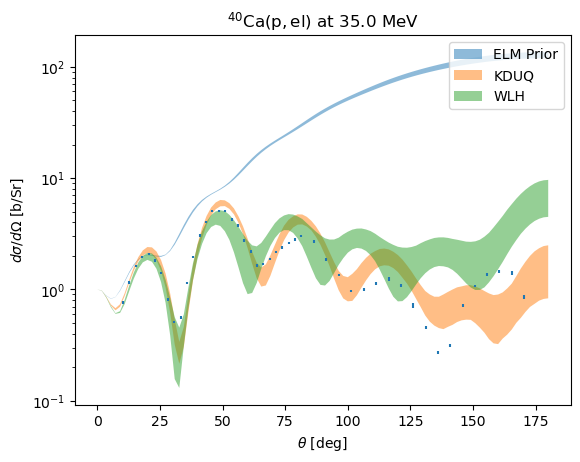

In [27]:
plt.title(f"${pp_data[(40, 20)].reaction.reaction_latex}$ at {constraints[i][1].kinematics.Elab} MeV")
plt.fill_between(angles_vis, elm_prior_confint[1], elm_prior_confint[0], alpha=0.5, label="ELM Prior")
plt.fill_between(angles_vis, kduq_confint[1], kduq_confint[0], alpha=0.5, label="KDUQ")
plt.fill_between(angles_vis, wlh_confint[1], wlh_confint[0], alpha=0.5, label="WLH")
plt.errorbar(constraints[i][0].x, constraints[i][0].y, constraints[i][0].stat_err_y, linestyle="none")

plt.yscale("log")
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r"$d \sigma/d\Omega$ [b/Sr]")
plt.legend()